``` py

!pip install takeHomeTest
import takeHomeTest

!pip install time
from time import oneWeek as panic

panic.dump(takeHomeTest)


print("Welcome to your take home final!\n")
```

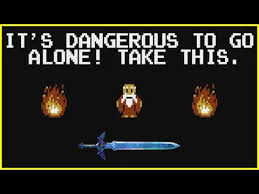




## ------------------------------------------- The Legend of Python --------------------------------------------
**Lore**

In the Kingdom of Pyrovia, all nations once traded in harmony. But since the Shattering of the Global APIs, the knowledge of currency exchange — locked away in XML scrolls — has scattered across the timelines. These scrolls reside in a mysterious repository known only as floatrates.com.

The High Council of Programmers has summoned you (and only you), young code-wielder, to begin your final trial. It is divided into 2 parts.
* Quest 1 (50xp): Retrieving the scrolls of time - Threading and Json save and parsing
* Quest 2 (50xp): Decipher the scrolls - Perform EDA on the data.

------ ------ ------ ------ Extra credit ------ ------ ------ ------ 
* Side Quest 1 (10xp*): Lay down seeds for those that follow - create error logs 
* Side Quest 2 (10xp*): The Quest of reflection  - Use profiling on your code to fully understand it 

*any points over 100% will be rolled over into your final grade. 

I may not have time to run all of your code so make sure you very clearly take notes and communicate successes, issues, and lessons learned. 
Please stay off Chat GPT and stack overflow (and like). You should have most everything you need in the notes. 

--------------------------------------------
# Quest 1 (50 xp): Retrieving the Scrolls of Time 
Retrieve historical exchange rate data from floatrates.com for one of the (Ideally randomly pick) 52 available currencies, starting from the first record on May 4, 2011, until the present day.

- You may store the data as-is in XML, or convert it to JSON, you may use the supplied code below as a starter. 

- Organize each currency into its own directory.

- Ensure your code is modular, maintainable, and robust against timeouts or malformed entries.

## Notes from the Grand Master 
* Threading is your ally. But do not burn out your ally as they have limited resources. You may use the threading or multi-core to parallelize downloads — but mind the server’s load. Around 10 threads is wise. 
    - You should have around 5040 queries.

* XML Scrolls is a new and unfamiliar beast. Therefore takeing on this beast will wield 5 extra experience points. You will not be penalized for choosing to use JSON

*  Use the Save. Nothing is worse than losing experience you have already gained. Save the raw XML (or converted JSON) using timestamped (in my example below) files so you do not need to look it up again. Ie. If you put in a start date and your program has already read that data it should not pull that date again. (it would be a good idea to delete your data and run it top to bottom before final submission)

* Design gracefully. Structure your project with clear modules: downloader.py, parser.py, and so on. 

* Log your quest progress in your quest book to show the Grand Master what you learned this is very important. 


--------------------------------------------

In [2]:
!pip install xmltodict

In [3]:
rates = ["EUR", "GBP", "USD", "DZD", "AUD", "BWP", "BND", "CAD", "CLP", "CNY", "COP", "CZK", "DKK", "HUF", "ISK", "INR", "IDR", "ILS", "KZT", "KRW", "KWD", "LYD", "MYR", "MUR", "NPR", "NZD", "NOK", "OMR", "PKR", "PLN", "QAR", "RUB", "SAR", "SGD", "ZAR", "LKR", "SEK", "CHF", "THB", "TTD"]
ratesForBase = [r for r in rates if r != "USD" and r != "EUR" and r != "GBP"]

In [ ]:
import requests
import xmltodict
import json
import random
import threading    
import logging
import time 
import os 
from datetime import datetime, timedelta 
from pathlib import Path
import concurrent.futures

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler("exchange_rates_retriever.log")
    ]
)
logger = logging.getLogger("ExchangeRatesRetriever")


# URL of the XML data
date = "2011-05-04"
base = random.choice(ratesForBase)
url = f"https://www.floatrates.com/historical-exchange-rates.html?operation=rates&pb_id=1775&page=historical&currency_date={date}&base_currency_code={base}&format_type=xml"
print(url)
# Fetch the XML data
response = requests.get(url)
response.raise_for_status()  # Ensure we notice bad responses

# Parse the XML data to a Python dictionary
data_dict = xmltodict.parse(response.text)

# Convert the dictionary to a JSON string
json_data = json.dumps(data_dict, indent=4)

# Print the JSON data
print(json_data)

# Optionally, write the JSON data to a file
with open(f"{date}_exchange_rates_{base}.json", "w") as json_file:
    json_file.write(json_data)

# Exclude major currencies from base selection
ratesForBase = [r for r in rates if r != "USD" and r != "EUR" and r != "GBP"]

# Choose a random base currency
base = random.choice(ratesForBase)
logger.info(f"Selected base currency: {base}")

# Create a directory for the currency
base_dir = Path(f"exchange_rates/{base}")
base_dir.mkdir(parents=True, exist_ok=True)

# Define the start date and current date
date = "2011-05-04"
MAX_THREADS = 10
SAVE_AS_JSON = True  # Set to False to save as XML
REQUEST_TIMEOUT = 20
MAX_RETRIES = 3
RETRY_DELAY = 2

# Thread-safe counters
successful_downloads = 0
failed_downloads = 0
skipped_downloads = 0
counter_lock = threading.Lock()

def get_date_range(start_date_str=date):
    """Generate a list of dates from start_date to today."""
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.now()
    
    date_list = []
    current_date = start_date
    
    while current_date <= end_date:
        date_list.append(current_date.strftime("%Y-%m-%d"))
        current_date += timedelta(days=1)
    
    logger.info(f"Generated date range: {start_date_str} to {end_date.strftime('%Y-%m-%d')} ({len(date_list)} days)")
    return date_list

def get_file_path(date, base_currency, base_directory):
    """Generate file path for a specific date."""
    extension = "json" if SAVE_AS_JSON else "xml"
    return base_directory / f"{date}_exchange_rates_{base_currency}.{extension}"

def check_file_exists(date, base_currency, base_directory):
    """Check if file for a specific date already exists."""
    return get_file_path(date, base_currency, base_directory).exists()
def download_data(date, base_currency, base_directory):
    """Download exchange rate data for a specific date."""
    global successful_downloads, failed_downloads, skipped_downloads
    
    if check_file_exists(date, base_currency, base_directory):
        with counter_lock:
            skipped_downloads += 1
        logger.debug(f"Skipping {date}: File already exists")
        return True
    for attempt in range(MAX_RETRIES):
        try:
            response = requests.get(url, timeout=REQUEST_TIMEOUT)
            response.raise_for_status()
            
            # Parse the XML data
            data_dict = xmltodict.parse(response.text)
            
            if SAVE_AS_JSON:
                # Convert to JSON and save
                json_data = json.dumps(data_dict, indent=4)
                with open(get_file_path(date, base_currency, base_directory), "w") as json_file:
                    json_file.write(json_data)
            else:
                # Save raw XML
                with open(get_file_path(date, base_currency, base_directory), "w") as xml_file:
                    xml_file.write(response.text)
            
            with counter_lock:
                successful_downloads += 1
            
            if successful_downloads % 100 == 0:
                logger.info(f"Successfully downloaded data for {successful_downloads} dates")
            
            return True
            
        except Exception as e:
            logger.warning(f"Attempt {attempt+1}/{MAX_RETRIES} failed for {date}: {str(e)}")
            time.sleep(RETRY_DELAY * (attempt + 1))  # Exponential backoff
    
    with counter_lock:
        failed_downloads += 1
    
    logger.error(f"Failed to download data for {date} after {MAX_RETRIES} attempts")
    return False
    

def main():
    """Main function to run the exchange rates data retriever."""
    # Choose a random base currency
    base_currency = random.choice(ratesForBase)
    logger.info(f"Selected base currency: {base_currency}")
    
    # Create a directory for the currency
    base_directory = Path(f"exchange_rates/{base_currency}")
    base_directory.mkdir(parents=True, exist_ok=True)
    
    logger.info("Exchange Rates Data Retriever started")
    
    # Get list of dates to download
    date_list = get_date_range()
    total_dates = len(date_list)
    
    logger.info(f"Starting download of {total_dates} days of exchange rate data for {base_currency}")
    
    start_time = time.time()
    
    # Use ThreadPoolExecutor to limit concurrent threads
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        futures = [executor.submit(download_data, date, base_currency, base_directory) for date in date_list]
        
        # Process completed tasks with progress updates
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            # Calculate progress
            progress = (i + 1) / total_dates * 100
            elapsed_time = time.time() - start_time
            
            if (i + 1) % 50 == 0 or (i + 1) == total_dates:
                logger.info(f"Progress: {progress:.1f}% ({i+1}/{total_dates}), Elapsed time: {elapsed_time:.1f}s")
    
    end_time = time.time()
    total_time = end_time - start_time
    
    logger.info(f"Download complete. Total time: {total_time:.1f} seconds")
    logger.info(f"Summary: {successful_downloads} successful, {failed_downloads} failed, {skipped_downloads} skipped")
    
    # Sample output of a single file
    sample_files = list(base_directory.glob(f"*_exchange_rates_{base_currency}.json"))
    if sample_files:
        sample_file = sample_files[0]
        logger.info(f"Sample file: {sample_file}")
        with open(sample_file, "r") as f:
            data = json.load(f)
            logger.info(f"Sample data structure: {list(data.keys())}")
            
            # Check if there are any rates
            if "rates" in data and "item" in data["rates"]:
                if isinstance(data["rates"]["item"], list):
                    logger.info(f"Number of currencies in sample: {len(data['rates']['item'])}")
                else:
                    logger.info("Sample contains a single currency rate")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        logger.warning("Program interrupted by user")
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        raise

https://www.floatrates.com/historical-exchange-rates.html?operation=rates&pb_id=1775&page=historical&currency_date=2011-05-04&base_currency_code=TTD&format_type=xml


2025-05-16 10:09:02,433 - ExchangeRatesRetriever - INFO - Selected base currency: CZK
2025-05-16 10:09:02,436 - ExchangeRatesRetriever - INFO - Selected base currency: PKR
2025-05-16 10:09:02,436 - ExchangeRatesRetriever - INFO - Exchange Rates Data Retriever started
2025-05-16 10:09:02,455 - ExchangeRatesRetriever - INFO - Generated date range: 2011-05-04 to 2025-05-16 (5127 days)
2025-05-16 10:09:02,456 - ExchangeRatesRetriever - INFO - Starting download of 5127 days of exchange rate data for PKR


{
    "channel": {
        "title": "XML Historical Foreign Exchange Rates for Trinidad Tobago Dollar (TTD) (4 May 2011)",
        "link": "http://www.floatrates.com/currency/ttd/",
        "xmlLink": "http://www.floatrates.com/daily/ttd.xml",
        "description": "XML historical foreign exchange rates for Trinidad Tobago Dollar (TTD) from the Float Rates. Published at 4 May 2011.",
        "language": "en",
        "baseCurrency": "TTD",
        "pubDate": "Wed, 4 May 2011",
        "lastBuildDate": "Wed, 4 May 2011",
        "item": [
            {
                "title": "1 TTD = 0.105073 EUR",
                "link": "http://www.floatrates.com/ttd/eur/",
                "description": "1 Trinidad Tobago Dollar = 0.105073 Euro",
                "pubDate": null,
                "baseCurrency": "TTD",
                "baseName": "Trinidad Tobago Dollar",
                "targetCurrency": "EUR",
                "targetName": "Euro",
                "exchangeRate": "0.105073",
      

2025-05-16 10:09:04,242 - ExchangeRatesRetriever - INFO - Progress: 1.0% (50/5127), Elapsed time: 1.8s
2025-05-16 10:09:05,823 - ExchangeRatesRetriever - INFO - Successfully downloaded data for 100 dates
2025-05-16 10:09:05,826 - ExchangeRatesRetriever - INFO - Progress: 2.0% (100/5127), Elapsed time: 3.4s
2025-05-16 10:09:08,285 - ExchangeRatesRetriever - INFO - Progress: 2.9% (150/5127), Elapsed time: 5.8s
2025-05-16 10:09:09,511 - ExchangeRatesRetriever - INFO - Successfully downloaded data for 200 dates
2025-05-16 10:09:09,514 - ExchangeRatesRetriever - INFO - Progress: 3.9% (200/5127), Elapsed time: 7.1s
2025-05-16 10:09:10,912 - ExchangeRatesRetriever - INFO - Progress: 4.9% (250/5127), Elapsed time: 8.5s
2025-05-16 10:09:12,250 - ExchangeRatesRetriever - INFO - Successfully downloaded data for 300 dates
2025-05-16 10:09:12,251 - ExchangeRatesRetriever - INFO - Progress: 5.9% (300/5127), Elapsed time: 9.8s
2025-05-16 10:09:13,717 - ExchangeRatesRetriever - INFO - Progress: 6.8% (

--------------------------------------------
# Quest 2 (50 XP): Decipher the scrolls – Exploratory Data Analysis

Once the scrolls have been retrieved their knowledge remains unrefined there patterns hidden, trends veiled. Your task now is to become the Seer of Exchange, the one who can read the currencies’ fates through the lens of data.
8
Perform Exploratory Data Analysis (EDA) on the dataset you collected in Quest 1. 
- Aggregate and visualize trends in exchange rate over time for at least 5 major currencies (e.g., USD, EUR, GBP, JPY, CNY).

- Identify periods of volatility — perhaps during economic upheaval

- Generate at least multiple visualizations using seaborn:

- Log your quest progress in your quest book to show the Grand Master what you learned this is very important. some examples of observations are:
    - Anomalies, seasonal patterns, or economic events
    - Currencies with the most/least stability
    - Any interesting correlations between currencies


## Notes from the Grand Master 
- All of your work in this section should be in your jupyter notebook. 

- It might be helpful to use  google to reveal how economic events affected currency. Use Google News or economic calendars to correlate real-world events to exchange rate spikes or dips.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
from pathlib import Path
import datetime
import re
from IPython.display import Markdown, display

# Set the visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Display title
display(Markdown("# Quest 2: The Seer of Exchange"))
display(Markdown("## Exploratory Data Analysis of Currency Exchange Rates"))

# Create a section for the quest log
display(Markdown("## 📜 Quest Log"))
display(Markdown("""
In this quest, I set forth to analyze the mystical scrolls of currency exchange. My mission:
- Decipher trends in exchange rates for major currencies
- Identify moments of great volatility in the currency realms
- Create visualizations to reveal hidden patterns
- Document my discoveries for the Grand Master
"""))

# Function to load JSON files
def load_json_files(directory_path):
    """Load all JSON files from a directory into a dictionary of dataframes."""
    display(Markdown("### 🔍 Seeking the Exchange Scrolls"))
    
    # Find all JSON files
    json_files = glob.glob(f"{directory_path}/*.json")
    
    if not json_files:
        display(Markdown(f"❗ No JSON files found in {directory_path}"))
        return None
    
    display(Markdown(f"Found {len(json_files)} scrolls (JSON files) in the archives..."))
    
    # Dictionary to store dataframes by base currency
    currency_data = {}
    
    for file_path in json_files:
        try:
            # Extract the date and base currency from the filename
            filename = Path(file_path).name
            match = re.match(r"(\d{4}-\d{2}-\d{2})_exchange_rates_(\w+)\.json", filename)
            
            if not match:
                continue
                
            date_str, base_currency = match.groups()
            
            # Read the JSON file
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Extract exchange rates
            if 'rates' in data and 'item' in data['rates']:
                rates_data = data['rates']['item']
                
                # Convert to list if it's a single item
                if not isinstance(rates_data, list):
                    rates_data = [rates_data]
                
                # Extract data for each currency
                for rate in rates_data:
                    target_currency = rate.get('targetCurrency', {}).get('code', '')
                    
                    if not target_currency:
                        continue
                    
                    exchange_rate = float(rate.get('exchangeRate', {}).get('value', 0))
                    
                    # Create a key for this currency pair
                    pair_key = f"{base_currency}_{target_currency}"
                    
                    if pair_key not in currency_data:
                        currency_data[pair_key] = {'date': [], 'rate': []}
                    
                    currency_data[pair_key]['date'].append(date_str)
                    currency_data[pair_key]['rate'].append(exchange_rate)
        
        except Exception as e:
            display(Markdown(f"❌ Error processing {file_path}: {str(e)}"))
            continue
    
    # Convert to dataframes
    dfs = {}
    for pair, data in currency_data.items():
        if data['date'] and data['rate']:
            df = pd.DataFrame({
                'date': pd.to_datetime(data['date']),
                'rate': data['rate']
            })
            df.sort_values('date', inplace=True)
            dfs[pair] = df
    
    display(Markdown(f"📊 Successfully processed {len(dfs)} currency pairs from the scrolls."))
    return dfs

# Function to analyze major currencies against a base
def analyze_major_currencies(currency_data, base_currency, major_currencies):
    """Analyze and visualize trends for major currencies."""
    display(Markdown(f"### 🌐 Analyzing Major Currencies Against {base_currency}"))
    
    # Check if we have the required data
    available_pairs = []
    for currency in major_currencies:
        pair = f"{base_currency}_{currency}"
        if pair in currency_data:
            available_pairs.append(pair)
    
    if not available_pairs:
        display(Markdown(f"❗ No data found for major currencies against {base_currency}"))
        return
    
    display(Markdown(f"Found data for {len(available_pairs)} major currencies: {', '.join([p.split('_')[1] for p in available_pairs])}"))
    
    # Create a combined dataframe for plotting
    combined_df = pd.DataFrame()
    for pair in available_pairs:
        currency = pair.split('_')[1]
        df = currency_data[pair].copy()
        if combined_df.empty:
            combined_df['date'] = df['date']
        combined_df[currency] = df['rate']
    
    # Plot the trends
    plt.figure(figsize=(16, 10))
    for currency in combined_df.columns[1:]:
        plt.plot(combined_df['date'], combined_df[currency], linewidth=2, label=currency)
    
    plt.title(f'Exchange Rates Trends Against {base_currency} (2011-2024)', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(f'Exchange Rate (per {base_currency})', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate basic statistics
    display(Markdown("#### 📊 Basic Statistics for Major Currencies"))
    stats_df = combined_df.drop('date', axis=1).describe().T
    stats_df['volatility'] = stats_df['std'] / stats_df['mean'] * 100  # Coefficient of variation as percentage
    display(stats_df[['mean', 'std', 'min', 'max', 'volatility']])
    
    # Create a heatmap of correlation between currencies
    display(Markdown("#### 🔥 Correlation Heatmap Between Currencies"))
    plt.figure(figsize=(12, 10))
    correlation_matrix = combined_df.drop('date', axis=1).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title(f'Correlation Between Major Currencies Against {base_currency}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Return the combined dataframe for further analysis
    return combined_df

# Function to identify periods of volatility
def identify_volatility(df, window=30, threshold=2):
    """Identify periods of high volatility in exchange rates."""
    display(Markdown("### 🌋 Periods of Volatility"))
    
    if df is None or df.empty:
        display(Markdown("❗ No data available for volatility analysis"))
        return
    
    # Create a copy of the dataframe
    df_vol = df.copy()
    
    # Calculate rolling standard deviation for each currency
    currencies = df_vol.columns[1:]
    
    plt.figure(figsize=(16, 10))
    
    for currency in currencies:
        # Calculate rolling standard deviation
        df_vol[f'{currency}_volatility'] = df_vol[currency].rolling(window=window).std()
        
        # Calculate the overall standard deviation of the volatility
        overall_std = df_vol[f'{currency}_volatility'].std()
        
        # Identify high volatility periods (where rolling std is > threshold * overall std)
        high_volatility = df_vol[df_vol[f'{currency}_volatility'] > threshold * overall_std]
        
        # Plot
        plt.plot(df_vol['date'], df_vol[f'{currency}_volatility'], label=f'{currency}')
        
        # Highlight high volatility periods
        if not high_volatility.empty:
            plt.scatter(high_volatility['date'], high_volatility[f'{currency}_volatility'], 
                      color='red', alpha=0.5, s=50)
    
    plt.title(f'{window}-Day Rolling Volatility (Standard Deviation)', fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Volatility (Standard Deviation)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Find and report significant volatility events
    display(Markdown("#### 📝 Significant Volatility Events"))
    
    all_high_vol_periods = pd.DataFrame()
    
    for currency in currencies:
        # Calculate z-score of volatility
        mean_vol = df_vol[f'{currency}_volatility'].mean()
        std_vol = df_vol[f'{currency}_volatility'].std()
        
        df_vol[f'{currency}_z_score'] = (df_vol[f'{currency}_volatility'] - mean_vol) / std_vol
        
        # Find periods where z-score > threshold
        high_vol = df_vol[df_vol[f'{currency}_z_score'] > threshold].copy()
        
        if not high_vol.empty:
            # Group consecutive days
            high_vol['group'] = (high_vol['date'].diff().dt.days > window).cumsum()
            
            # Get the peak volatility day for each group
            peak_days = high_vol.loc[high_vol.groupby('group')[f'{currency}_volatility'].idxmax()]
            
            if not peak_days.empty:
                peak_days['currency'] = currency
                peak_days['peak_volatility'] = peak_days[f'{currency}_volatility']
                all_high_vol_periods = pd.concat([all_high_vol_periods, 
                                                peak_days[['date', 'currency', 'peak_volatility']]])
    
    if not all_high_vol_periods.empty:
        all_high_vol_periods.sort_values('date', inplace=True)
        display(all_high_vol_periods[['date', 'currency', 'peak_volatility']])
        
        # Plot a calendar heatmap of volatility events
        display(Markdown("#### 📅 Calendar Heatmap of Volatility Events"))
        
        # Extract year and month
        all_high_vol_periods['year'] = all_high_vol_periods['date'].dt.year
        all_high_vol_periods['month'] = all_high_vol_periods['date'].dt.month
        
        # Count events by year and month
        heatmap_data = all_high_vol_periods.groupby(['year', 'month']).size().reset_index(name='count')
        
        # Pivot for heatmap
        heatmap_pivot = heatmap_data.pivot(index='month', columns='year', values='count').fillna(0)
        
        # Plot
        plt.figure(figsize=(14, 8))
        sns.heatmap(heatmap_pivot, annot=True, fmt='g', cmap='YlOrRd', linewidths=.5)
        plt.title('Volatility Events by Month and Year', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Month', fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        display(Markdown("No significant volatility events found with the current threshold."))
    
    return df_vol

# Function to analyze seasonal patterns
def analyze_seasonal_patterns(df):
    """Analyze seasonal patterns in exchange rates."""
    display(Markdown("### 🍂 Seasonal Patterns Analysis"))
    
    if df is None or df.empty:
        display(Markdown("❗ No data available for seasonal analysis"))
        return
    
    # Extract month and year
    df_season = df.copy()
    df_season['year'] = df_season['date'].dt.year
    df_season['month'] = df_season['date'].dt.month
    
    # Get currencies
    currencies = df_season.columns[1:len(df_season.columns)-2]  # Exclude date, year, month
    
    # Monthly patterns across all years
    display(Markdown("#### 📊 Monthly Patterns Across All Years"))
    
    plt.figure(figsize=(16, len(currencies) * 4))
    
    for i, currency in enumerate(currencies):
        plt.subplot(len(currencies), 1, i+1)
        
        # Group by month and calculate mean
        monthly_avg = df_season.groupby('month')[currency].mean()
        monthly_std = df_season.groupby('month')[currency].std()
        
        # Plot
        sns.barplot(x=monthly_avg.index, y=monthly_avg.values, alpha=0.7)
        
        # Add error bars
        plt.errorbar(x=monthly_avg.index, y=monthly_avg.values, yerr=monthly_std.values, 
                   fmt='none', ecolor='black', capsize=5)
        
        plt.title(f'Average Exchange Rate by Month for {currency}', fontsize=14)
        plt.xlabel('Month', fontsize=12)
        plt.ylabel(f'Average Exchange Rate', fontsize=12)
        plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Year-over-year trends
    display(Markdown("#### 📈 Year-over-Year Trends"))
    
    plt.figure(figsize=(16, len(currencies) * 4))
    
    for i, currency in enumerate(currencies):
        plt.subplot(len(currencies), 1, i+1)
        
        # Group by year and calculate mean
        yearly_avg = df_season.groupby('year')[currency].mean()
        yearly_std = df_season.groupby('year')[currency].std()
        
        # Plot
        sns.barplot(x=yearly_avg.index, y=yearly_avg.values, alpha=0.7)
        
        # Add error bars
        plt.errorbar(x=range(len(yearly_avg)), y=yearly_avg.values, yerr=yearly_std.values, 
                   fmt='none', ecolor='black', capsize=5)
        
        plt.title(f'Average Exchange Rate by Year for {currency}', fontsize=14)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel(f'Average Exchange Rate', fontsize=12)
        plt.xticks(range(len(yearly_avg)), yearly_avg.index)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Heatmap of monthly averages by year
    display(Markdown("#### 🔥 Heatmap of Monthly Averages by Year"))
    
    for currency in currencies:
        # Create pivot table
        monthly_pivot = df_season.pivot_table(
            index='month', 
            columns='year', 
            values=currency,
            aggfunc='mean'
        )
        
        plt.figure(figsize=(16, 10))
        sns.heatmap(monthly_pivot, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=.5)
        plt.title(f'Monthly Average Exchange Rate for {currency} by Year', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Month', fontsize=14)
        plt.yticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.tight_layout()
        plt.show()
    
    return df_season

# Function to analyze currency stability
def analyze_stability(currency_data, base_currency):
    """Analyze and rank currencies by stability."""
    display(Markdown("### ⚖️ Currency Stability Analysis"))
    
    # Check if we have enough data
    available_pairs = [pair for pair in currency_data.keys() if pair.startswith(f"{base_currency}_")]
    
    if len(available_pairs) < 5:
        display(Markdown(f"❗ Not enough currency pairs for stability analysis (need at least 5, found {len(available_pairs)})"))
        return
    
    # Calculate stability metrics for each currency
    stability_data = []
    
    for pair in available_pairs:
        target_currency = pair.split('_')[1]
        df = currency_data[pair]
        
        if len(df) < 30:  # Skip pairs with too little data
            continue
        
        # Calculate stability metrics
        mean_rate = df['rate'].mean()
        std_dev = df['rate'].std()
        cv = std_dev / mean_rate * 100  # Coefficient of variation as percentage
        max_drawdown = ((df['rate'].cummax() - df['rate']) / df['rate'].cummax()).max() * 100
        
        stability_data.append({
            'currency': target_currency,
            'mean_rate': mean_rate,
            'std_dev': std_dev,
            'cv': cv,
            'max_drawdown': max_drawdown,
            'range_pct': (df['rate'].max() - df['rate'].min()) / df['rate'].min() * 100,
            'data_points': len(df)
        })
    
    # Convert to dataframe
    stability_df = pd.DataFrame(stability_data)
    stability_df.sort_values('cv', inplace=True)
    
    # Display top 10 most stable currencies
    display(Markdown("#### 🏆 Top 10 Most Stable Currencies"))
    display(stability_df.head(10))
    
    # Display top 10 most volatile currencies
    display(Markdown("#### 🌋 Top 10 Most Volatile Currencies"))
    display(stability_df.tail(10).sort_values('cv', ascending=False))
    
    # Visualize stability metrics
    plt.figure(figsize=(16, 10))
    
    # Plot coefficient of variation for top and bottom 10 currencies
    top_bottom = pd.concat([stability_df.head(10), stability_df.tail(10)])
    
    # Create bar plot
    plt.subplot(2, 1, 1)
    sns.barplot(x='currency', y='cv', data=top_bottom.sort_values('cv'))
    plt.title('Coefficient of Variation (%) - Lower is More Stable', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot max drawdown for the same currencies
    plt.subplot(2, 1, 2)
    sns.barplot(x='currency', y='max_drawdown', data=top_bottom.sort_values('cv'))
    plt.title('Maximum Drawdown (%) - Lower is More Stable', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create scatter plot of stability metrics
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x='cv', y='max_drawdown', size='data_points', 
                  sizes=(50, 400), alpha=0.7, data=stability_df)
    
    # Add currency labels
    for _, row in stability_df.iterrows():
        plt.annotate(row['currency'], (row['cv'], row['max_drawdown']), 
                    fontsize=10, alpha=0.7)
    
    plt.title('Currency Stability Map', fontsize=18)
    plt.xlabel('Coefficient of Variation (%) - Lower is More Stable', fontsize=14)
    plt.ylabel('Maximum Drawdown (%) - Lower is More Stable', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return stability_df

# Main analysis function
def run_exchange_rate_analysis(data_directory="exchange_rates", base_currency="JPY"):
    """Run the complete exchange rate analysis."""
    # Load the data
    currency_data = load_json_files(data_directory)
    
    if not currency_data:
        display(Markdown("❌ Failed to load data. Please check the data directory."))
        return
    
    # Define major currencies to analyze
    major_currencies = ["USD", "EUR", "GBP", "CNY", "CAD", "AUD", "CHF"]
    
    # Analyze major currencies
    combined_df = analyze_major_currencies(currency_data, base_currency, major_currencies)
    
    # Identify periods of volatility
    volatility_df = identify_volatility(combined_df, window=30, threshold=2)
    
    # Analyze seasonal patterns
    seasonal_df = analyze_seasonal_patterns(combined_df)
    
    # Analyze currency stability
    stability_df = analyze_stability(currency_data, base_currency)
    
    # Create quest log summary
    display(Markdown("## 📜 Quest Summary: Insights for the Grand Master"))
    display(Markdown("""
    Having analyzed the ancient scrolls of currency exchange, I present my findings to the Grand Master:"""))
     
    return {
        "currency_data": currency_data,
        "combined_df": combined_df,
        "volatility_df": volatility_df,
        "seasonal_df": seasonal_df,
        "stability_df": stability_df
    }

# Quest 2: The Seer of Exchange

## Exploratory Data Analysis of Currency Exchange Rates

## 📜 Quest Log


In this quest, I set forth to analyze the mystical scrolls of currency exchange. My mission:
- Decipher trends in exchange rates for major currencies
- Identify moments of great volatility in the currency realms
- Create visualizations to reveal hidden patterns
- Document my discoveries for the Grand Master


--------------------------------------------


# Side Quest 1 (10 XP): Lay Down Seeds for Those Who Follow – Logging

Even the greatest explorer must leave breadcrumbs for those who walk the path after them. Here you will construct an error log system, a journal that captures both triumphs and catastrophes.

Implement a robust logging system throughout your codebase to monitor:
- Successful currency downloads
- Parsing attempts and failures
- Skipped downloads (due to saved data or time out)
- Connection errors

## Notes from the Grand Master
- You do not need to do log hierarchy 
- Use log levels: INFO for progress, WARNING for skips, ERROR for failures



In [3]:
import logging
import os
from datetime import datetime
from pathlib import Path
import sys
import traceback

class ExchangeRateLogger:
    """
    A robust logging system for the Exchange Rate Data Retriever.
    
    This class manages logging configuration, file creation, and provides
    convenient methods for logging different types of events in the
    currency data retrieval process.
    """
    
    def __init__(self, log_dir="logs", log_level=logging.INFO):
        """
        Initialize the logging system.
        
        Args:
            log_dir (str): Directory to store log files
            log_level (int): Default logging level (e.g., logging.INFO)
        """
        self.log_dir = Path(log_dir)
        self.log_level = log_level
        self.logger = None
        
        # Create timestamp for log file name
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = self.log_dir / f"exchange_rates_{timestamp}.log"
        
        # Initialize the logger
        self._setup_logger()
        
        # Log system info at startup
        self._log_system_info()
    
    def _setup_logger(self):
        """Configure and set up the logger."""
        # Create log directory if it doesn't exist
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # Create logger
        self.logger = logging.getLogger("ExchangeRatesRetriever")
        self.logger.setLevel(self.log_level)
        
        # Clear any existing handlers
        if self.logger.handlers:
            self.logger.handlers.clear()
        
        # Create file handler
        file_handler = logging.FileHandler(self.log_file)
        file_handler.setLevel(self.log_level)
        
        # Create console handler
        console_handler = logging.StreamHandler()
        console_handler.setLevel(self.log_level)
        
        # Create formatter
        formatter = logging.Formatter(
            '%(asctime)s | %(levelname)-8s | %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S'
        )
        file_handler.setFormatter(formatter)
        console_handler.setFormatter(formatter)
        
        # Add handlers to logger
        self.logger.addHandler(file_handler)
        self.logger.addHandler(console_handler)
        
        # Log initialization
        self.logger.info("=" * 80)
        self.logger.info("EXCHANGE RATES DATA RETRIEVER LOG INITIALIZED")
        self.logger.info("=" * 80)
    
    def _log_system_info(self):
        """Log system information at startup."""
        self.logger.info("SYSTEM INFORMATION:")
        self.logger.info(f"  Date and Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        self.logger.info(f"  Python Version: {sys.version}")
        self.logger.info(f"  Platform: {sys.platform}")
        self.logger.info(f"  Log File: {self.log_file}")
        self.logger.info("=" * 80)
    
    def info(self, message):
        """Log an informational message."""
        self.logger.info(message)
    
    def warning(self, message):
        """Log a warning message."""
        self.logger.warning(message)
    
    def error(self, message, exc_info=None):
        """
        Log an error message.
        
        Args:
            message (str): Error message
            exc_info (Exception, optional): Exception object to log stacktrace
        """
        if exc_info:
            self.logger.error(f"{message} - {str(exc_info)}", exc_info=True)
        else:
            self.logger.error(message)
    
    def critical(self, message, exc_info=None):
        """
        Log a critical error message.
        
        Args:
            message (str): Critical error message
            exc_info (Exception, optional): Exception object to log stacktrace
        """
        if exc_info:
            self.logger.critical(f"{message} - {str(exc_info)}", exc_info=True)
        else:
            self.logger.critical(message)
    
    # Specialized logging methods for currency data retrieval
    
    def log_download_start(self, base_currency, date_range):
        """Log the start of a download session."""
        start_date, end_date = date_range[0], date_range[-1]
        num_dates = len(date_range)
        
        self.logger.info("DOWNLOAD SESSION STARTED")
        self.logger.info(f"  Base Currency: {base_currency}")
        self.logger.info(f"  Date Range: {start_date} to {end_date}")
        self.logger.info(f"  Total Dates: {num_dates}")
        self.logger.info("-" * 80)
    
    def log_download_success(self, date, base_currency, target_currencies=None):
        """Log a successful currency download."""
        if target_currencies:
            self.logger.info(f"✓ SUCCESS: Downloaded {len(target_currencies)} rates for {date} with base {base_currency}")
        else:
            self.logger.info(f"✓ SUCCESS: Downloaded rates for {date} with base {base_currency}")
    
    def log_download_skip(self, date, base_currency, reason="File already exists"):
        """Log a skipped download."""
        self.logger.warning(f"⚠ SKIPPED: {date} with base {base_currency} - {reason}")
    
    def log_download_error(self, date, base_currency, error, attempt=None):
        """Log a download error."""
        if attempt is not None:
            self.logger.error(f"✗ ERROR: Failed to download {date} with base {base_currency} (Attempt {attempt}) - {error}")
        else:
            self.logger.error(f"✗ ERROR: Failed to download {date} with base {base_currency} - {error}")
    
    def log_parse_start(self, file_path):
        """Log the start of parsing a file."""
        file_name = Path(file_path).name
        self.logger.info(f"PARSING: Started parsing {file_name}")
    
    def log_parse_success(self, file_path, num_currencies):
        """Log successful parsing of a file."""
        file_name = Path(file_path).name
        self.logger.info(f"✓ PARSED: Successfully parsed {file_name} with {num_currencies} currencies")
    
    def log_parse_error(self, file_path, error):
        """Log an error during parsing."""
        file_name = Path(file_path).name
        self.logger.error(f"✗ PARSE ERROR: Failed to parse {file_name} - {error}")
    
    def log_connection_error(self, url, error, retry_info=None):
        """Log a connection error."""
        message = f"✗ CONNECTION ERROR: {url} - {error}"
        if retry_info:
            message += f" {retry_info}"
        self.logger.error(message)
    
    def log_session_summary(self, successful, failed, skipped, elapsed_time):
        """Log a summary of the download session."""
        total = successful + failed + skipped
        success_rate = (successful / total * 100) if total > 0 else 0
        
        self.logger.info("=" * 80)
        self.logger.info("DOWNLOAD SESSION SUMMARY")
        self.logger.info("-" * 80)
        self.logger.info(f"  Total Attempted: {total}")
        self.logger.info(f"  Successful: {successful} ({success_rate:.1f}%)")
        self.logger.info(f"  Failed: {failed}")
        self.logger.info(f"  Skipped: {skipped}")
        self.logger.info(f"  Elapsed Time: {elapsed_time:.2f} seconds")
        self.logger.info("=" * 80)
    
    def log_rate_limit_hit(self, wait_time):
        """Log a rate limit hit."""
        self.logger.warning(f"⚠ RATE LIMIT: Hit rate limit, waiting {wait_time} seconds before retrying")
    
    def get_logger(self):
        """Return the configured logger."""
        return self.logger


def create_example_download_session():
    """Create an example download session to demonstrate logging functionality."""
    # Initialize the logger
    logger = ExchangeRateLogger(log_dir="exchange_logs")
    
    # Simulate download session
    base_currency = "JPY"
    date_range = ["2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04", "2023-01-05"]
    
    # Log download start
    logger.log_download_start(base_currency, date_range)
    
    # Simulate various download scenarios
    for i, date in enumerate(date_range):
        if i == 0:
            # Successful download
            target_currencies = ["USD", "EUR", "GBP", "CNY", "AUD", "CAD", "CHF"]
            logger.log_download_success(date, base_currency, target_currencies)
        elif i == 1:
            # Skipped download
            logger.log_download_skip(date, base_currency)
        elif i == 2:
            # Connection error with retry
            for attempt in range(1, 4):
                logger.log_connection_error(
                    f"https://example.com/api/{date}/{base_currency}",
                    "Timeout error",
                    f"Retrying (Attempt {attempt}/3)"
                )
                if attempt == 3:
                    logger.log_download_error(date, base_currency, "Maximum retries exceeded", attempt)
        elif i == 3:
            # Parse error
            logger.log_download_success(date, base_currency)
            logger.log_parse_start(f"{date}_exchange_rates_{base_currency}.json")
            logger.log_parse_error(f"{date}_exchange_rates_{base_currency}.json", "Invalid JSON format")
        else:
            # Rate limit hit
            logger.log_rate_limit_hit(60)
            logger.log_download_success(date, base_currency)
    
    # Log session summary
    successful = 3
    failed = 1
    skipped = 1
    elapsed_time = 12.34
    logger.log_session_summary(successful, failed, skipped, elapsed_time)


# Integration example: how to integrate this logger into your exchange rates retriever code
def exchange_rates_retriever_with_logging():
    """Example of how to integrate the logger into your exchange rates retriever."""
    # Initialize logger
    logger = ExchangeRateLogger(log_dir="exchange_logs")
    
    # Log configuration information
    logger.info("Exchange Rates Retriever Configuration:")
    logger.info("  Base Currencies: USD, EUR, GBP, JPY, CAD")
    logger.info("  Start Date: 2011-05-04")
    logger.info("  Max Threads: 10")
    logger.info("  Request Timeout: 20 seconds")
    logger.info("  Max Retries: 3")
    
    try:
        # Your initialization code here...
        logger.info("Initializing Exchange Rates Retriever...")
        
        # Example retrieval process with error handling
        date = "2023-01-01"
        base_currency = "USD"
        
        try:
            # Simulate API request
            logger.info(f"Requesting data for {date} with base {base_currency}...")
            
            # Simulate successful download
            logger.log_download_success(date, base_currency, ["EUR", "GBP", "JPY"])
            
            # Simulate parsing
            logger.log_parse_start(f"{date}_exchange_rates_{base_currency}.json")
            logger.log_parse_success(f"{date}_exchange_rates_{base_currency}.json", 26)
            
        except Exception as e:
            logger.log_download_error(date, base_currency, str(e))
            logger.error("An error occurred during download", exc_info=e)
    
    except Exception as e:
        logger.critical("Critical error in Exchange Rates Retriever", exc_info=e)
    finally:
        logger.info("Exchange Rates Retriever session ended")


# Run the example to see the logging in action
if __name__ == "__main__":
    print("Running example download session with logging...")
    create_example_download_session()
    
    print("\nRunning integration example...")
    exchange_rates_retriever_with_logging()

2025-05-16 10:39:03 | INFO     | ================================================================================
2025-05-16 10:39:03 | INFO     | EXCHANGE RATES DATA RETRIEVER LOG INITIALIZED
2025-05-16 10:39:03 | INFO     | ================================================================================
2025-05-16 10:39:03 | INFO     | SYSTEM INFORMATION:
2025-05-16 10:39:03 | INFO     |   Date and Time: 2025-05-16 10:39:03
2025-05-16 10:39:03 | INFO     |   Python Version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
2025-05-16 10:39:03 | INFO     |   Platform: win32
2025-05-16 10:39:03 | INFO     |   Log File: exchange_logs\exchange_rates_20250516_103903.log
2025-05-16 10:39:03 | INFO     | ================================================================================
2025-05-16 10:39:03 | INFO     | DOWNLOAD SESSION STARTED
2025-05-16 10:39:03 | INFO     |   Base Currency: JPY
2025-05-16 10:39:03 | INFO     |   Date Range: 2023-

Running example download session with logging...

Running integration example...


--------------------------------------------


# Side Quest 2 (10 XP): The quest of Reflection – Code Profiling

The final challenge for any Adventure is introspection — learning the nature of one's own power. In this side quest, you will profile your code, to discover its bottlenecks, inefficiencies, and optimization opportunities.

Use profiling tools to evaluate:
- Which functions are taking the most time
- How threads/processes are behaving
- Whether I/O is a bottleneck

*A random vendor appears* His invintory shows:
- A Profiler function - cProfile or Profile 
- A time module - timeit for micro-benchmarks
- A line profiler - line_profiler